### Approach

The code is divided into the following sections with notes / observations after each output:

Data Preparation

I Preprocessing
- Data granularity and keys understanding
- Missing values analysis, imputation and evalutation
- Outlier / junk values detection and treatment
  
II Exploratory Data Analaysis
- Univariate distributions 
- Bivariate analysis 
- Barplots for categorical features (X-y)
- Scatterplots and histograms for numerical features (X-X and X-y)

Feature Selection (and Model Development)

III Heuristic Methods
- Vizualisations
- Statistical Measures
- Correlations
- Variance Inflation Factor 

IV Filter Methods
- ANOVA Test for continuous features
- Chi-Square Test for categorical features
   
V Embedded Methods
- Feature Importance analysis using tree-based models
- Algorithms: Decision Tree, XGboost
- Model tuning, cross-validation using Gridsearch

In [96]:
#importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

In [5]:
#Loading the data
df_raw = pd.read_csv("DS_customer_data_sample.csv")
print(df_raw.shape)
display(df_raw.head())

(891, 10)


,customer_id,converted,customer_segment,gender,age,related_customers,family_size,initial_fee_level,credit_account_id,branch
0,15001,0,13,male,22.0,1,0,14.5000,9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6...,Helsinki
1,15002,1,11,female,38.0,1,0,142.5666,afa2dc179e46e8456ffff9016f91396e9c6adf1fe20d17...,Tampere
2,15003,1,13,female,26.0,0,0,15.8500,9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6...,Helsinki
3,15004,1,11,female,35.0,1,0,106.2000,abefcf257b5d2ff2816a68ec7c84ec8c11e0e0dc4f3425...,Helsinki
4,15005,0,13,male,35.0,0,0,16.1000,9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6...,Helsinki


In [6]:
#checking for null values
(df_raw.isnull().sum()/df_raw.shape[0] * 100).apply("{0:.1f}".format)

customer_id           0.0
converted             0.0
customer_segment      0.0
gender                0.0
age                  19.9
related_customers     0.0
family_size           0.0
initial_fee_level     0.0
credit_account_id     0.0
branch                0.2
dtype: object

In [7]:
#checking for duplicate ids
df=df_raw.copy()
print("ID count:",df.customer_id.count(),"\nUnique ID count:",df.customer_id.nunique())
display(df[df.duplicated(['customer_id'], keep=False)])

#observation: data is unique at customer ID level

ID count: 891 
Unique ID count: 891


,customer_id,converted,customer_segment,gender,age,related_customers,family_size,initial_fee_level,credit_account_id,branch


In [264]:
#cleaning
df['credit_account_id'].replace({"9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6c9bc9d493a23be9de0":"NA"}, inplace=True)

#check count of NAs and duplicity of account id
df[['credit_account_id','customer_id']].groupby(['credit_account_id'])['customer_id'] \
                                       .count().reset_index(name='count').sort_values(['count'], ascending=False).head(5)

#observations:
    #1. only 204 of the customers have a credit account ID
    #2. 46 of these account IDs are one-to-many mapped to customer ID
    #3. discarding the feature from analysis

,credit_account_id,count
90,NA,687
69,780d558be6960a54064f888577409d1c92eb7c3d6c65e6...,4
132,f0d3a2a5176986eddfdd60b0b303d8fd7c4dfe3060479f...,4
114,cec0a7de7f8d6fc385250a76e38555a1f45fd5aaeb1a2b...,4
81,8e2de3335023201ffa4d803767bdf12790c58f4f241554...,3


### Univariate Analysis

array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'converted'}>,
        <AxesSubplot:title={'center':'customer_segment'}>],
       [<AxesSubplot:title={'center':'family_size'}>,
        <AxesSubplot:title={'center':'initial_fee_level'}>,
        <AxesSubplot:title={'center':'related_customers'}>]], dtype=object)

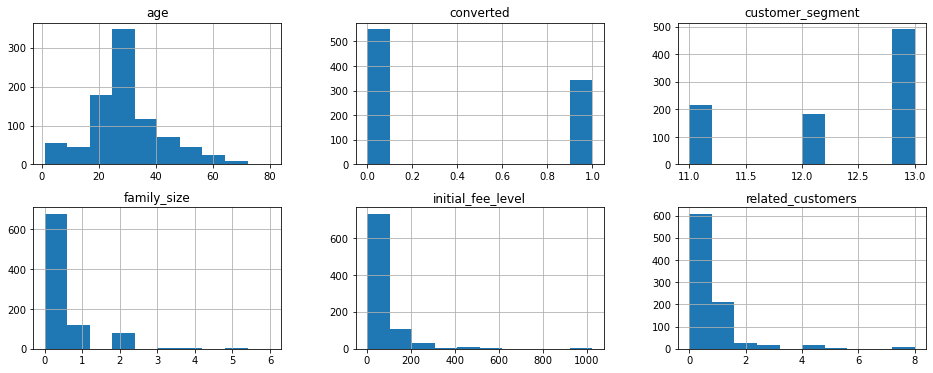

In [132]:
#histograms
df.loc[:, df.columns.difference(['customer_id'])].hist(figsize=(16, 6),layout=(2,3))

Observations:
1. Dependent variable 'converted' does not have class imbalance
2. 'age' is roughly right skewed and has junk values of <1
3. Some features (related_customers, family_size, initial_fee_level) have exponential decay distributions

In [133]:
#checking skewness and kurtosis of age for normality
print(df['age'].agg(['skew','kurtosis']).transpose())

skew        0.512584
kurtosis    0.992390
Name: age, dtype: float64


Observations: 
1. fairly symmetrical and only slightly thicker tail than normal distribution
2. acceptable ranges for normal distribution qualification

### Missing Values Imputation

In [12]:
#replacing age <1 values with 1
df['age']=df['age'].apply(lambda x:1 if x<1 else x)

#imputation
df['age'].fillna(df['age'].median(), inplace=True)

#checking distribution before and after imputation
print("Raw:",df_raw.age.describe().apply("{0:.2f}".format))
print("\nImputed:",df.age.describe().apply("{0:.2f}".format))

#notes:
    #1. assumption: all ages 1 or above are considered valid, only age <1 treated as junk value
    #2. there is no pattern to missing-values, imputation through feature relationship not possible
    #3. selecting median for imputation to minimise variance distortion of the right skewed age

Raw: count    714.00
mean      29.70
std       14.53
min        0.42
25%       20.12
50%       28.00
75%       38.00
max       80.00
Name: age, dtype: object

Imputed: count    891.00
mean      29.36
std       13.02
min        1.00
25%       22.00
50%       28.00
75%       35.00
max       80.00
Name: age, dtype: object


In [259]:
#branch imputation
df['branch'].fillna(df['branch'].mode()[0], inplace=True)

#checking distributions before and after imputation
print("Raw:\n",df_raw.branch.value_counts())
print("\nImputed:\n",df.branch.value_counts())

Raw:
 Helsinki    644
Tampere     168
Turku        77
Name: branch, dtype: int64

Imputed:
 Helsinki    646
Tampere     168
Turku        77
Name: branch, dtype: int64


In [260]:
#separating numeric and catagorical features
df_num = df[['age','related_customers','family_size','initial_fee_level','converted']]
df_cat = df[['customer_segment','gender','branch']]

#one-hot encoding
df_dummy=pd.get_dummies(df_cat, columns=df_cat.columns)
df_dummy.head()

#note: considering ordinal categorical features of related_customers and family_size as continuous

,customer_segment_11,customer_segment_12,customer_segment_13,gender_female,gender_male,branch_Helsinki,branch_Tampere,branch_Turku
0,0,0,1,0,1,1,0,0
1,1,0,0,1,0,0,1,0
2,0,0,1,1,0,1,0,0
3,1,0,0,1,0,1,0,0
4,0,0,1,0,1,1,0,0


### Barplots of Categorical Features

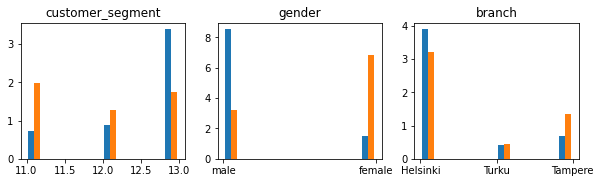

In [66]:
#barplots with colour-coded dependant variable
df_0=df_cat[df['converted']==0]
df_1=df_cat[df['converted']==1]

fig, axes = plt.subplots(1, 3,figsize=[10,2.5])
axes = axes.flatten()
i=0
for x in df_cat.columns:
    plt.sca(axes[i])
    plt.hist([df_0[x],df_1[x]],density=True)
    plt.title(x)
    i+=1
plt.show()

### Bi-Variate Scatterplots

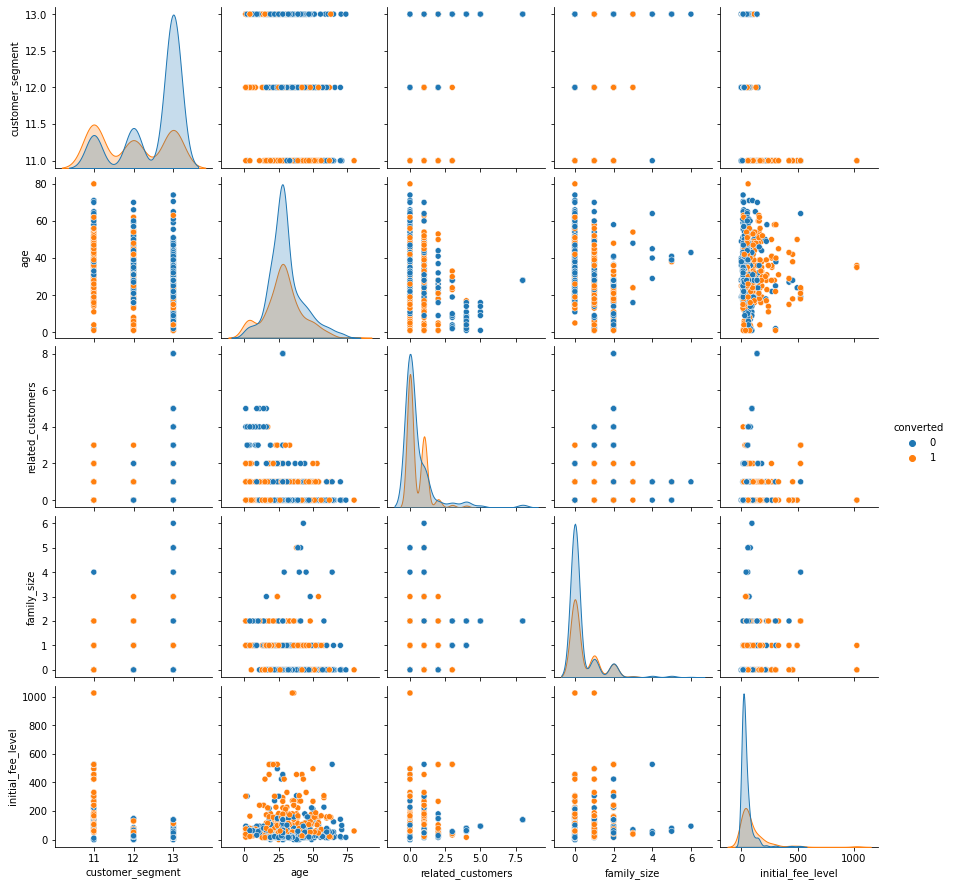

In [84]:
#scatterplots with colour-coded dependant variable
%matplotlib inline

reqd_features=['converted','customer_segment', 'gender', 'age','related_customers', 'family_size', 'initial_fee_level','branch']
df_subset=df[reqd_features]
sns.pairplot(df_subset,hue='converted')

Observations from bar and scatter plots:
1. segment 13 leads have very high propensity for non-conversion
2. product / service seems to be targeted at females
5. under 25 leads with 3 or more related customers are most likely to not convert
6. leads are most likely to convert if they have 1 related customer
4. Helsinki: most rejects, Turku: worst conversion rate, Tampere: best conversion rate
7. family size and related customers seem correlated, to be tested statistically

### Pearson's Correlation

In [122]:
#feature correlation
corr_matrix=(df_num.corr())
corr_matrix.style.background_gradient(cmap='coolwarm')

,age,related_customers,family_size,initial_fee_level
age,1.000000,-0.233328,-0.172394,0.096688
related_customers,-0.233328,1.000000,0.414838,0.159651
family_size,-0.172394,0.414838,1.000000,0.216225
initial_fee_level,0.096688,0.159651,0.216225,1.000000


Observations: 
1. family size moderately correlated to related customers 
2. only weak to moderate correlation among predictors and dependant variable

### VIF to detect multicollinearity

In [261]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

#VIF computation
def compute_vif(considered_features):
    X = df[considered_features]
    X['intercept'] = 1
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif[vif['Variable']!='intercept']
    return vif

In [263]:
y=df_num['converted']
df_num=df_num.drop(['converted'],axis=1)
cols_for_vif = list(df_num.columns)
compute_vif(cols_for_vif)

C:\Users\Pallavi Bhat\AppData\Local\Temp/ipykernel_15012/3522162666.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


,Variable,VIF
0,age,1.092125
1,related_customers,1.262927
2,family_size,1.258119
3,initial_fee_level,1.082116


Observation: VIF is not >5 for any feature, multi-collinearity absent 

### ANOVA Test for Continuous Features

             Feature  F-statistic       P-value
3  initial_fee_level    63.030764  6.120189e-15
2        family_size     5.963464  1.479925e-02
0                age     3.740889  5.341325e-02
1  related_customers     1.110572  2.922439e-01


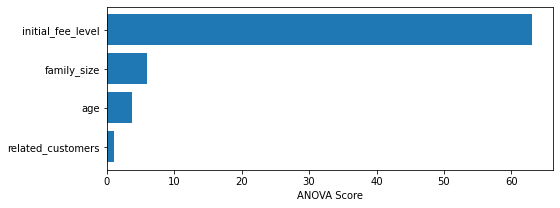

In [165]:
#best numeric features from ANOVA
from sklearn.feature_selection import SelectKBest, f_classif, chi2
bestfeatures = SelectKBest(score_func=f_classif, k='all')
fit = bestfeatures.fit(df_num,y)

#putting scores into table
df_scores = pd.DataFrame(fit.scores_)
df_pvalues = pd.DataFrame(fit.pvalues_)
df_columns = pd.DataFrame(df_num.columns)
df_anova = pd.concat([df_columns,df_scores,df_pvalues],axis=1)
df_anova.columns = ['Feature','F-statistic','P-value']
df_anova=df_anova.sort_values(by='F-statistic')
print(df_anova.nlargest(4,'F-statistic'))

#plotting scores
plt.xlabel("ANOVA Score")
plt.barh(df_anova["Feature"], df_anova["F-statistic"])
plt.show()

Observations:
1. ANOVA is used to assess how well continuous features discriminate between the two y classes (0 and 1)
2. age and related customers have low score, can be considered for removal

### Chi-Square Test for Categorical Features

               Feature       Chi-2       P-value
3        gender_female  170.348127  6.210585e-39
4          gender_male   92.702447  6.077838e-22
0  customer_segment_11   55.175151  1.102538e-13
2  customer_segment_13   41.553071  1.147141e-10
6       branch_Tampere   20.464401  6.075071e-06
1  customer_segment_12    6.160767  1.306146e-02
5      branch_Helsinki    5.984840  1.442935e-02
7         branch_Turku    0.010847  9.170520e-01


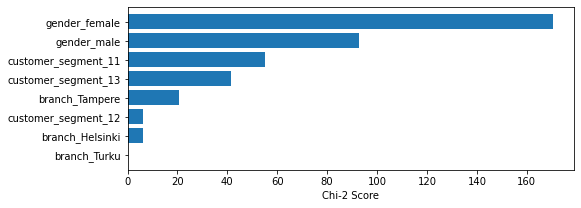

In [159]:
#best categorical features from chi-square
bestfeatures = SelectKBest(score_func=chi2, k='all')
fit = bestfeatures.fit(df_dummy,y)

#putting scores into table
df_scores = pd.DataFrame(fit.scores_)
df_pvalues = pd.DataFrame(fit.pvalues_)
df_columns = pd.DataFrame(df_dummy.columns)
df_chisquare = pd.concat([df_columns,df_scores,df_pvalues],axis=1)
df_chisquare.columns = ['Feature','Chi-2','P-value']
df_chisquare=df_chisquare.sort_values(by='Chi-2')
print(df_chisquare.nlargest(10,'Chi-2'))

#plotting scores
plt.xlabel("Chi-2 Score")
plt.rcParams["figure.figsize"] = (8,3)
plt.barh(df_chisquare["Feature"], df_chisquare["Chi-2"])
plt.show()

Observations:
1. This test is used to quantify feature importance of categorical features for classification models
2. Gender male, customer segment 12 and Branch Turku (one class each from each categorical feature, to avoid redundancy of information) to be removed from analysis due to low Chi-square scores

#### Dropping features based on the above statistical tests

In [206]:
#merging dummies and numeric continuous features
X=pd.concat([df_dummy,df_num], axis = 1,join='inner')

#dropping insignificant features 
X=X.drop(['related_customers','customer_segment_12','gender_male','branch_Turku'], axis=1)

### Embedded Methods For Feature Selection
#### Using tree-based algorithms


In [217]:
from sklearn.model_selection import train_test_split
#splitting to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size =0.25,
                                                    stratify=y,
                                                    random_state=111)

print(X_train.shape,X_test.shape)

(668, 8) (223, 8)


Notes: 
1. features not scaled since scaling is not needed for splitting criteria in tree-based algorithms
2. since no scaling is done, there is no need for log transformation of exponential decaying continuous features

### Iteration 1: Decision Tree

f1_train:  0.8619957537154989
f1_test:  0.7142857142857143


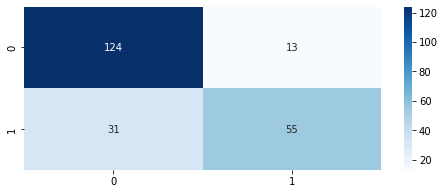

In [235]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(criterion='gini', max_depth=10, min_samples_split=2, min_samples_leaf=2)

#train
model.fit(X_train, y_train)
y_pred_train = model.predict(X_train)
y_pred = model.predict(X_test)

#performance evaluation
print("f1_train: ", f1_score(y_train, y_pred_train))
print("f1_test: ", f1_score(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap="Blues"); #annot=True to annotate cells fmt: format

Observations:
1. model is overfit with a poor performance on test set 
2. checking the feature importance first
3. then improving the model performance for better feature-importance identification using:
        a) gridsearch to tune parameters
        b) ensemble tree-based algorithm
4. feature importances finalized by comparing the average outcomes of various models

AxesSubplot(0.125,0.125;0.775x0.755)


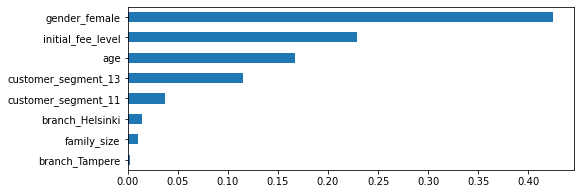

In [239]:
feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
print(feat_importances.nsmallest(12).plot(kind='barh'))

### Iteration 2: Decision Tree with GridSearchCV
(best parameters and k-fold crossvalidated)

In [246]:
#DT classifier
classifier = DecisionTreeClassifier()
parameters = {'criterion': ['entropy','gini'], 
              'max_depth': [3,5,10, 50],
              'min_samples_split': [5,10],
              'min_samples_leaf': [2,4]}
from sklearn.model_selection import GridSearchCV
gs = GridSearchCV(classifier, parameters, cv=3, scoring = 'f1', verbose=10, n_jobs=-1)
gs = gs.fit(X_train, y_train)

#summarize gridsearch results
print("Best score: %f using %s" % (gs.best_score_, gs.best_params_))
means = gs.cv_results_['mean_test_score']
stds = gs.cv_results_['std_test_score']
params = gs.cv_results_['params']
best_model = gs.best_estimator_
y_pred = best_model.predict(X_test)
y_pred_train = best_model.predict(X_train)

Fitting 3 folds for each of 32 candidates, totalling 96 fits
Best score: 0.755790 using {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 5}


Observation: Test F1 score shows only minute improvement from 71.5% to 75.5%, trying ensemble tree algorithms next

<AxesSubplot:>

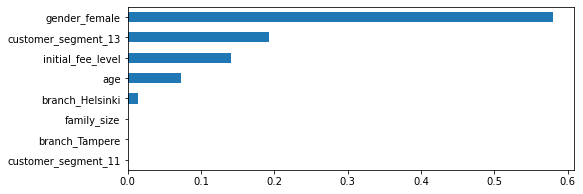

In [247]:
feat_importances = pd.Series(best_model.feature_importances_, index=X_train.columns)
feat_importances.nsmallest(8).plot(kind='barh')

### Iteration 3: XGBoost

In [250]:
#XGBoost
model = XGBClassifier()
eval_set = [(X_test, y_test)]
model.fit(X_train, y_train, early_stopping_rounds=10, eval_metric="logloss", eval_set=eval_set, verbose=True)
y_pred_train = model.predict(X_train)
y_pred = model.predict(X_test)
print("f1_train: ", f1_score(y_train, y_pred_train))
print("f1_test: ", f1_score(y_test, y_pred))

[0]	validation_0-logloss:0.58066
[1]	validation_0-logloss:0.52261
[2]	validation_0-logloss:0.48879
[3]	validation_0-logloss:0.47177
[4]	validation_0-logloss:0.46341
[5]	validation_0-logloss:0.45391
[6]	validation_0-logloss:0.45684
[7]	validation_0-logloss:0.45777
[8]	validation_0-logloss:0.45489
[9]	validation_0-logloss:0.46137
[10]	validation_0-logloss:0.46588
[11]	validation_0-logloss:0.46698
[12]	validation_0-logloss:0.46816
[13]	validation_0-logloss:0.46943
[14]	validation_0-logloss:0.46840
f1_train:  0.8333333333333333
f1_test:  0.7114093959731544


C:\Users\Pallavi Bhat\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


### Iteration 4: XGBoost with GridSearchCV

In [251]:
#running gridsearch to counter overfitting seen in default parameters
#reducing learning rate, increasing gamma, reducing max depth
classifier = XGBClassifier()
parameters = {"learning_rate":[0.05,0.1,0.2],"gamma":[1,2,3],"max_depth":[2,4,6]}
gs = GridSearchCV(classifier, parameters, cv=5, scoring = 'f1', verbose=50, n_jobs=-1, refit=True)
gs = gs.fit(X_train, y_train)

#summarize gridsearch results
print("Best score: %f using %s" % (gs.best_score_, gs.best_params_))
means = gs.cv_results_['mean_test_score']
stds = gs.cv_results_['std_test_score']
params = gs.cv_results_['params']

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[10:57:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best score: 0.749898 using {'gamma': 3, 'learning_rate': 0.2, 'max_depth': 4}


C:\Users\Pallavi Bhat\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [252]:
#Best XGB from gridsearch:
model = XGBClassifier(gamma=3, learning_rate=0.2, max_depth=4)
eval_set = [(X_test, y_test)]
model.fit(X_train, y_train, early_stopping_rounds=10, eval_metric="logloss", eval_set=eval_set, verbose=True)
y_pred_train = model.predict(X_train)
y_pred = model.predict(X_test)
print("f1_train: ", f1_score(y_train, y_pred_train))
print("f1_test: ", f1_score(y_test, y_pred))

[0]	validation_0-logloss:0.61169
[1]	validation_0-logloss:0.55801
[2]	validation_0-logloss:0.52181
[3]	validation_0-logloss:0.49884
[4]	validation_0-logloss:0.47957
[5]	validation_0-logloss:0.46863
[6]	validation_0-logloss:0.45999
[7]	validation_0-logloss:0.45475
[8]	validation_0-logloss:0.44992
[9]	validation_0-logloss:0.44749
[10]	validation_0-logloss:0.44523
[11]	validation_0-logloss:0.44687
[12]	validation_0-logloss:0.44701
[13]	validation_0-logloss:0.44648
[14]	validation_0-logloss:0.44679
[15]	validation_0-logloss:0.44677
[16]	validation_0-logloss:0.44675
[17]	validation_0-logloss:0.44675
[18]	validation_0-logloss:0.44674
[19]	validation_0-logloss:0.44602
f1_train:  0.7876288659793815
f1_test:  0.7151515151515152


Note: All models perform decently, with only slight improvement after tuning. There is still significant amount of overfitting present. However, these models are only used as Embedded methods for feature selection, as a next step, other algorithms can be utilized to yield better results.

<AxesSubplot:>

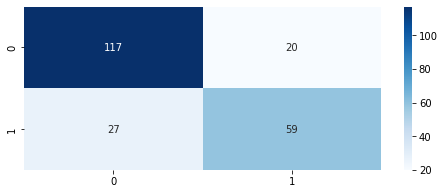

In [253]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap="Blues")

<AxesSubplot:>

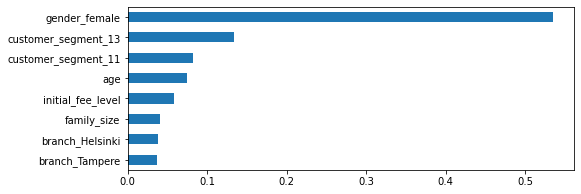

In [254]:
feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
feat_importances.nsmallest(12).plot(kind='barh')

In [255]:
print(feat_importances.sort_values(ascending=False))

gender_female          0.534736
customer_segment_13    0.133822
customer_segment_11    0.082641
age                    0.074197
initial_fee_level      0.058219
family_size            0.041353
branch_Helsinki        0.037794
branch_Tampere         0.037237
dtype: float32


Note: Process flow, Observations and Conclusions are in the report